# GeoMAC Perimeters

### Summary

This notebook demonstrates an Object Oriented Programming (OOP) implementation of a benchmarking system to compare a FEDS fire perimeter against other fire perimeter data sources, and then store in an output object. 

*This particularly demonstrates ability to iterate over all available FEDS and create mass analysis results*

NOTE: This notebook was run in 1-2 month intervals due to the FEDS API item limit. For your range, if you recieve an error on the limit, try to reduce your time window. A single year may need to be broken into ~8-10 intervals. In atypical cases, a single month may need to be split. Users should apply trial-and-error.

#### Sources for demonstration:
- <span style='color:red'> **FEDS Archived Perimeters** </span>, labeled as `"public.eis_fire_lf_perimeter_archive"` and graphically displayed as <span style='color:red'> red </span>
-  <span style='color:#B8860B'> **NIFC InterAgency History Perimeters** </span>, labeled as `"Downloaded_InterAgencyFirePerimeterHistory_All_Years_View"`and graphically displayed as  <span style='color:#B8860B'> transparent gold with hatch style </span>

The FEDS input and reference input can use either a pre-defined setting or can accept (valid) user-written paths to shape files. 
- For Input all settings, please see **section INPUT SETTINGS of README.md**  
- Output settings can also be modified to control if calculations are printed, plotted, and/or stored into a file (with location and file type of choice); for more detail on outputs please see **section OUTPUT SETTINGS of README.md**

#### Motivation 
FEDS-PEC eliminates the need for users to recreate/repeat solutions when conducting geospatial data evaluations. By leveraging this module, researchers and analysts can quickly and efficiently compare the FEDS fireperimeter dataset against a reference data set of their choosing. Users can focus their efforts on dataset selection and analysis, rather than spending time implementing and testing software for comparisons and calculations.

#### Debugging
Should users encounter abnormal errors, users are encouraged to restart the kernel of the notebook and re-run blocks. 

### User Inputs for Comparison: time, bbox, FEDS set, reference set

Note for inputs:

FEDS Input: you must specify a valid title (e.g. firenrt) and collection (e.g. public.eis_fire_lf_perimeter_archive) according to documentation. Please see **section INPUT SETTINGS of README.md** for valid titles and corresponding collections

Reference Input: See **section INPUT SETTINGS of README.md** for valid titles and corresponding collections

In [1]:
import sys
sys.path.append('../') # local path append

# for crs suppression
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import Utilities
import Input_FEDS
import Input_Reference
import Output_Calculation

from Input_FEDS import InputFEDS
from Input_Reference import InputReference
from Output_Calculation import OutputCalculation
from Utilities import *

In [2]:
# this is the ONLY section users are intended to modify!
# inputs for searching FEDS and nifc sets

# START TIME
year_start = 2019
month_start = 10 
day_start = 17
hour_start = 0
minute_start = 0
second_start = 0
tz_offset_hours_start = 0
tz_offset_minutes_start = 0
utc_offset_start = '00:00'

# END TIME
year_stop = 2019
month_stop = 10
day_stop = 17
hour_stop = 2
minute_stop = 0
second_stop = 0
tz_offset_hours_stop = 0
tz_offset_minutes_stop = 0
utc_offset_stop = '00:00'

# CRS - 4326 RECOMMENDED FEDS FIRE PERIM DEFAULT
crs = 3857 # 4326

# BBOX FOR SEARCH - [lon, lat, lon, lat]
search_bbox = ["-125.0", "24.396308", "-66.93457", "49.384358"] 

# DAY SEARCH RANGE- acceptable distance warning to search from feds -> reference (e.g. if reference polygon is 8 days away, output a warning)
# note by default, any results not of the same year are eliminated
day_search_range = 7 

# FEDS INPUT SETTINGS
feds_title = "firenrt"
feds_collection =  "public.eis_fire_lf_perimeter_archive"
feds_access_type = "api"
feds_limit = 9000 # amount of features to consider for FEDS API access; warning appears if it misses any entries
feds_filter = False
feds_apply_finalfire = True

# REFERENCE INPUT SETTINGS 
ref_title ="Historic_GeoMAC_Perimeters_2019"
ref_control_type = "defined" # or "custom"
ref_custom_url = "none"
ref_custom_read_type = "none"
ref_filter = False # False or a valid query

# OUTPUT SETTINGS - User discretion advised for path functionality
print_on = True
plot_on = True
name_for_output_file = "compare_interagency_v_geomac"
output_format = "csv"
user_path = "/projects/my-public-bucket/VEDA-PEC/results"
output_maap_url = f"{user_path}/{name_for_output_file}.{output_format}"

### Argument Processing: format and check to report any issues
- Note: upon instance instantiation we can also get reports back of invalidity -> any warnings/errors should be addressed

In [3]:

# start date formatting
search_start = Utilities.format_datetime(year_start, 
                                         month_start, 
                                         day_start, 
                                         hour_start, 
                                         minute_start, 
                                         second_start, 
                                         tz_offset_hours_start, 
                                         tz_offset_minutes_start,
                                         utc_offset_start)
# stop date formatting
search_stop = Utilities.format_datetime(year_stop, 
                                        month_stop, 
                                        day_stop, 
                                        hour_stop, 
                                        minute_stop, 
                                        second_stop, 
                                        tz_offset_hours_stop, 
                                        tz_offset_minutes_stop,
                                        utc_offset_stop)

# bound check the bbox
assert Utilities.check_bbox(search_bbox), f"ERR: passed bbox {search_bbox} is not valid; check bounds"
assert  Utilities.check_crs(crs), f"ERR: invalid crs provided {crs}; please enter valid ESPG CRS number"

### Using Inputs: Instantiate Inputs + Calculation Output

With our inputs, we are ready to start; run this to get the program to fetch the FEDS candidates in the provided time/location window, along with an intersecting NIFC in the specific day range

You may see an ERROR 1 occur; ignore this unless block throws actual exception...


Running FEDS-Reference Match Algorithm:  11%|█▏        | 8/71 [00:15<02:03,  1.96s/polygon]

TIME MATCH WARNING: the intersecting pair does not have a timestamp difference within the specified day search range window: 7 
Intersection pair will still be included for user inspection; FEDS at index 8 and Reference at index [643, 1593]. 


Running FEDS-Reference Match Algorithm:  25%|██▌       | 18/71 [00:35<01:44,  1.97s/polygon]

TIME MATCH WARNING: the intersecting pair does not have a timestamp difference within the specified day search range window: 7 
Intersection pair will still be included for user inspection; FEDS at index 18 and Reference at index [1768]. 


Running FEDS-Reference Match Algorithm:  42%|████▏     | 30/71 [00:59<01:20,  1.97s/polygon]

TIME MATCH WARNING: the intersecting pair does not have a timestamp difference within the specified day search range window: 7 
Intersection pair will still be included for user inspection; FEDS at index 30 and Reference at index [1263, 1280]. 


Running FEDS-Reference Match Algorithm:  55%|█████▍    | 39/71 [01:17<01:02,  1.95s/polygon]

TIME MATCH WARNING: the intersecting pair does not have a timestamp difference within the specified day search range window: 7 
Intersection pair will still be included for user inspection; FEDS at index 39 and Reference at index [128, 423]. 


Running FEDS-Reference Match Algorithm: 100%|██████████| 71/71 [02:20<00:00,  1.97s/polygon]


DATE MATCHING COMPLETE
NO CALCULATION RESULTS, SKIP FEDS INDEX 29 & REFERENCE INDEX 29
NO CALCULATION RESULTS, SKIP FEDS INDEX 14 & REFERENCE INDEX 14
NO CALCULATION RESULTS, SKIP FEDS INDEX 70 & REFERENCE INDEX 70
NO CALCULATION RESULTS, SKIP FEDS INDEX 5 & REFERENCE INDEX 5
CALCULATED A RESULT: POLYGON FEDS AT INDEX 59 AGAINST REFERENCE POLYGON AT INDEX 940:
Ratio: 1.9895332244853257, Accuracy: 0.8699927338022583, Precision: 0.5017376321176663, Recall: 0.9982236890726927, IOU: 0.319712712016576, F1 0.6678124068981006, Symmetric Ratio: 0.9930858463399442
All measurements in units metre
NO CALCULATION RESULTS, SKIP FEDS INDEX 11 & REFERENCE INDEX 11
NO CALCULATION RESULTS, SKIP FEDS INDEX 4 & REFERENCE INDEX 4
NO CALCULATION RESULTS, SKIP FEDS INDEX 58 & REFERENCE INDEX 58
CALCULATED A RESULT: POLYGON FEDS AT INDEX 28 AGAINST REFERENCE POLYGON AT INDEX 704:
Ratio: 1.494038936543304, Accuracy: 0.8489454378581138, Precision: 0.6652372486411225, Recall: 0.9938903515087762, IOU: 0.40565528

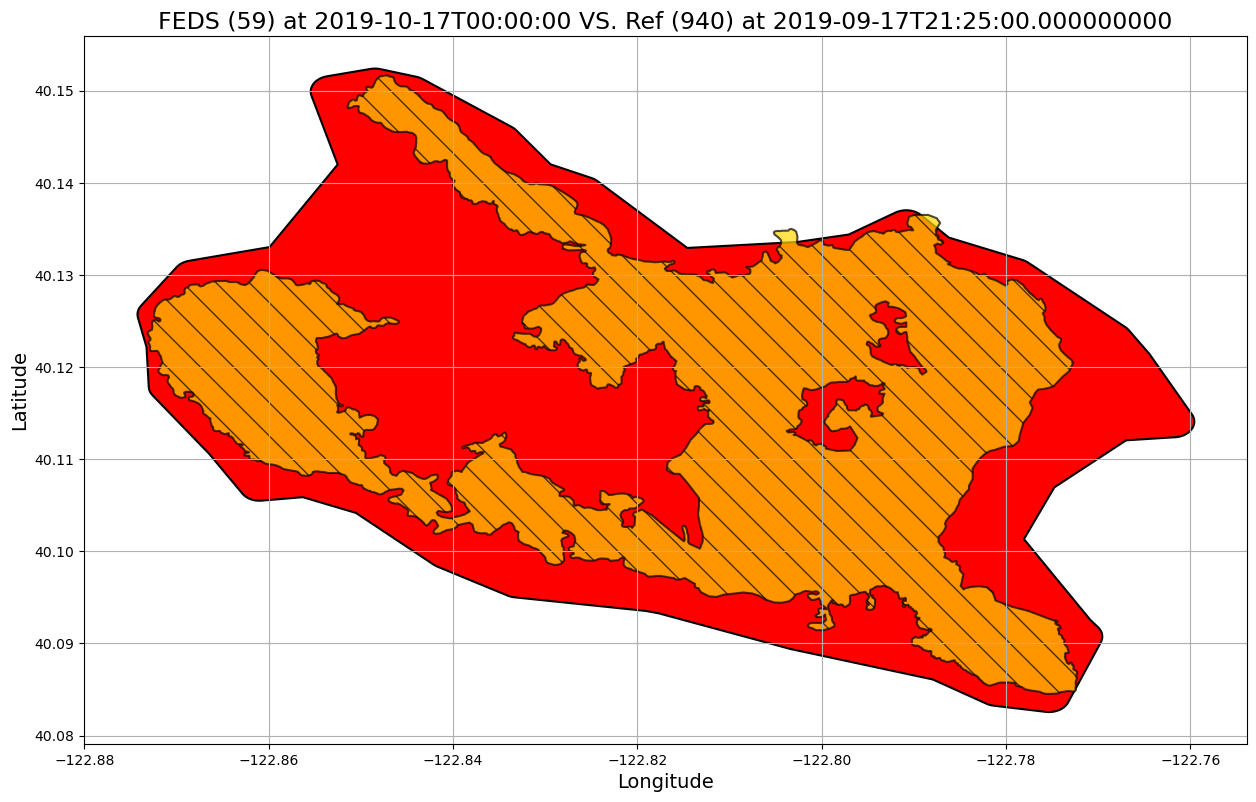

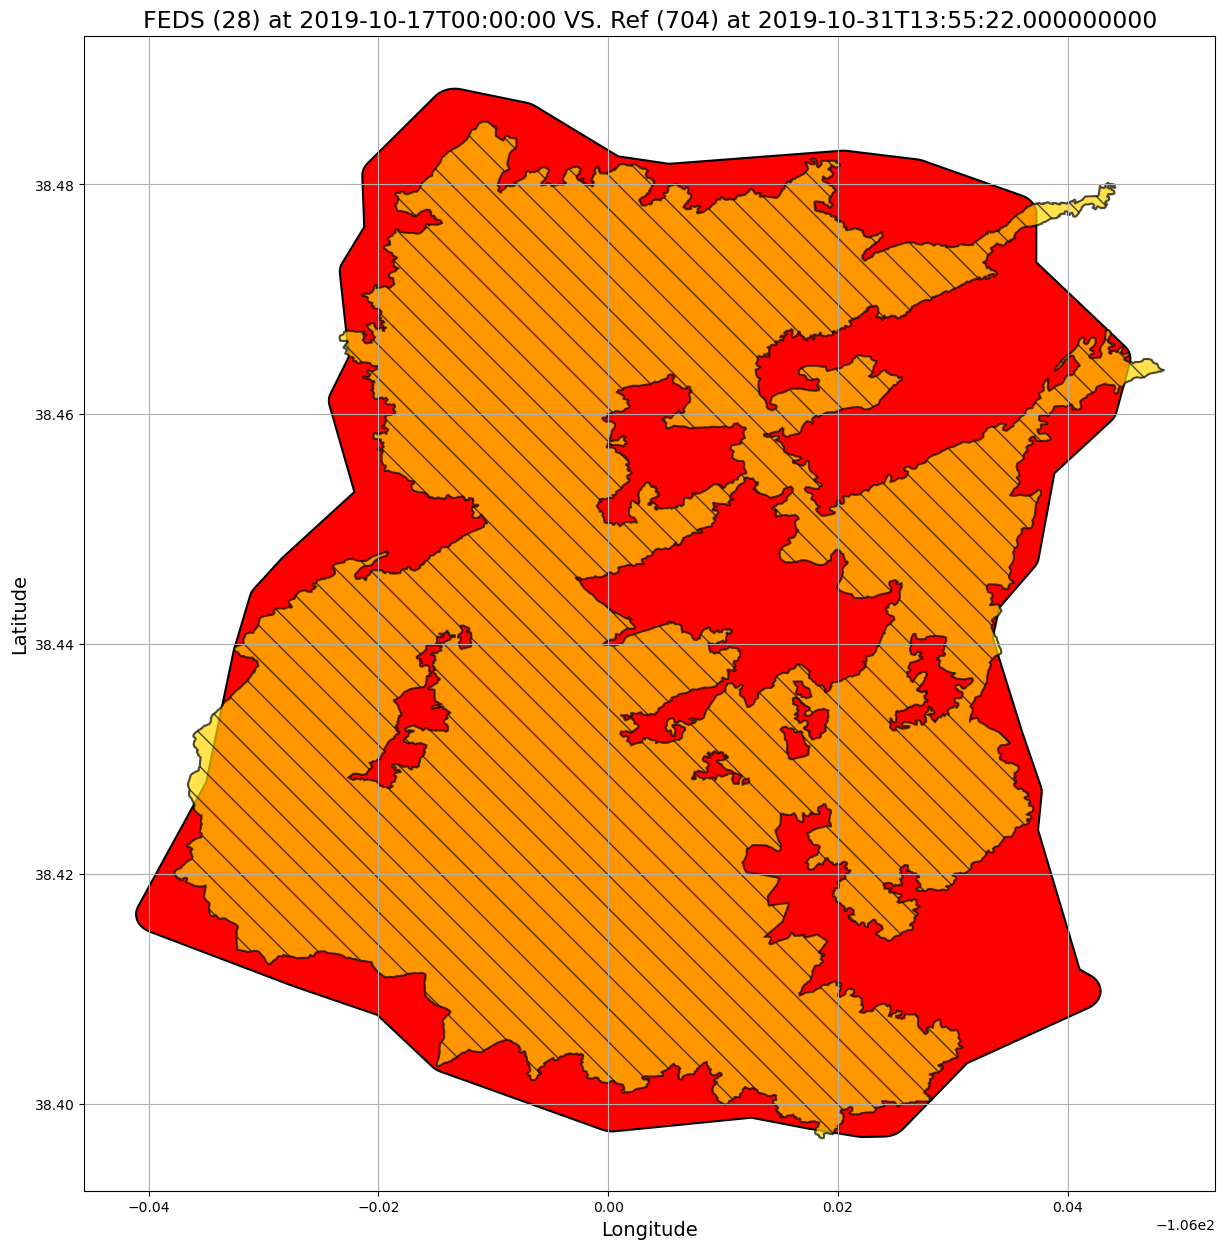

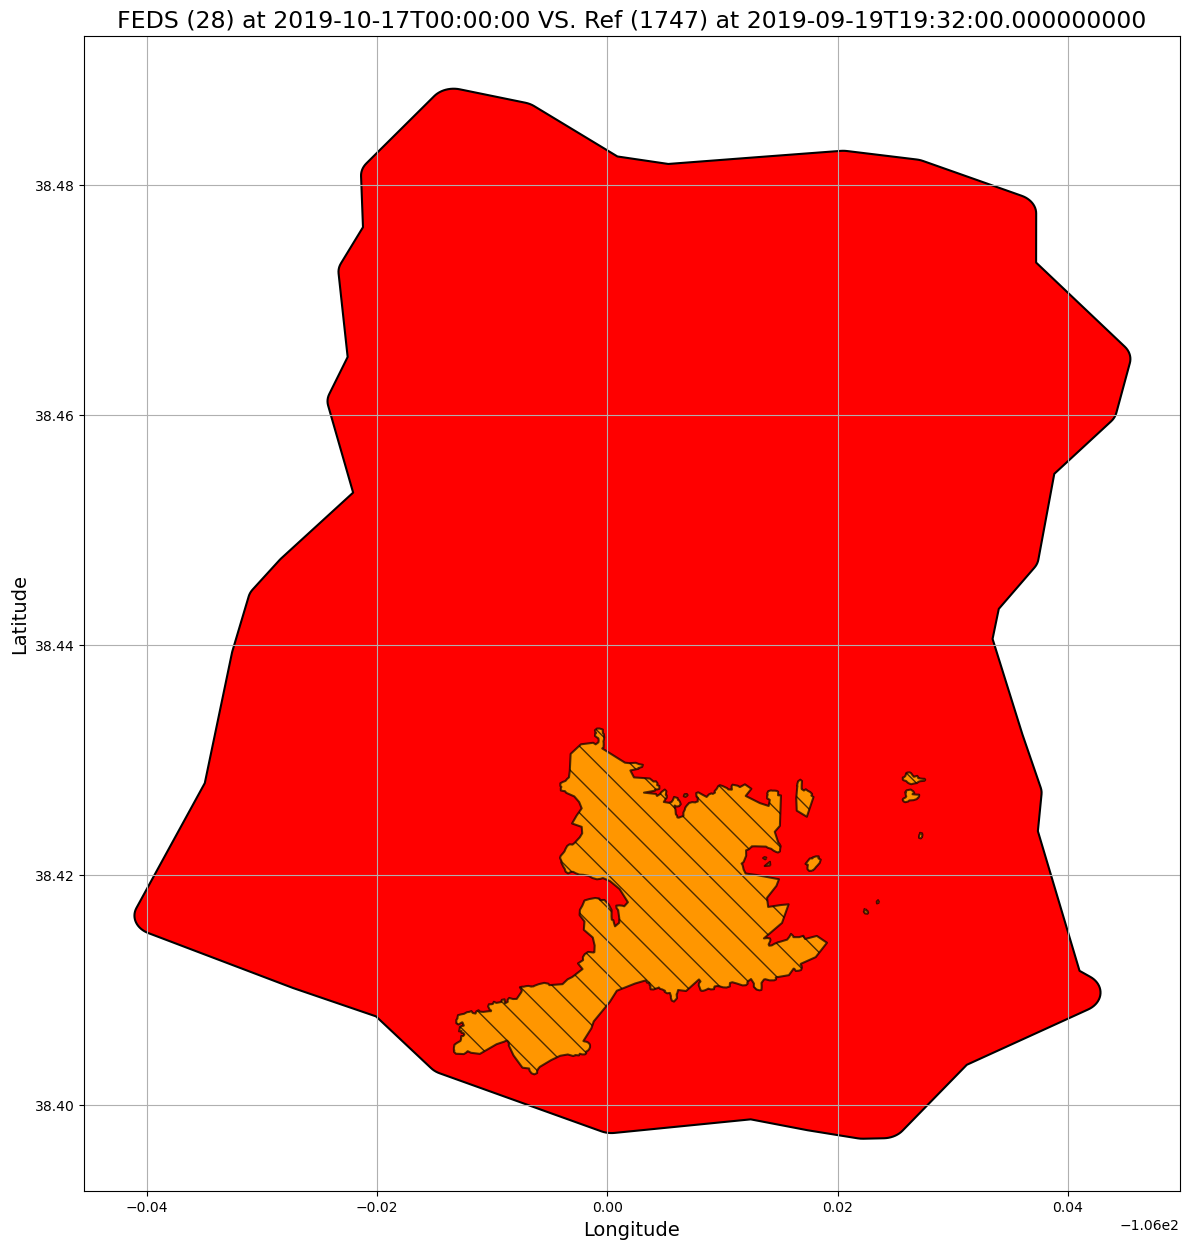

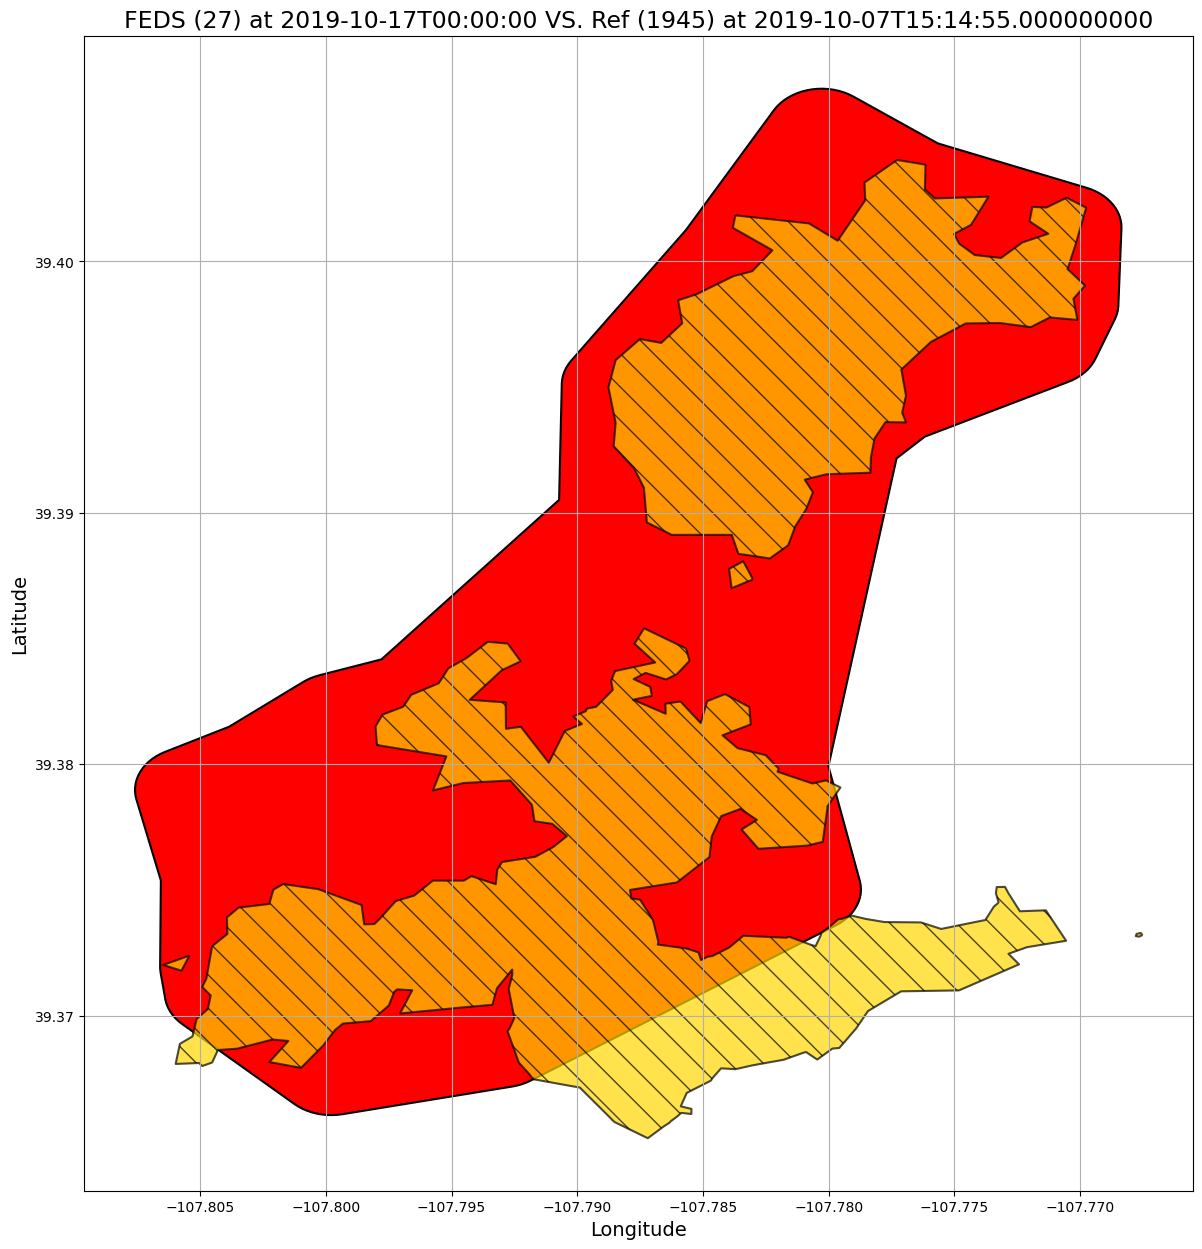

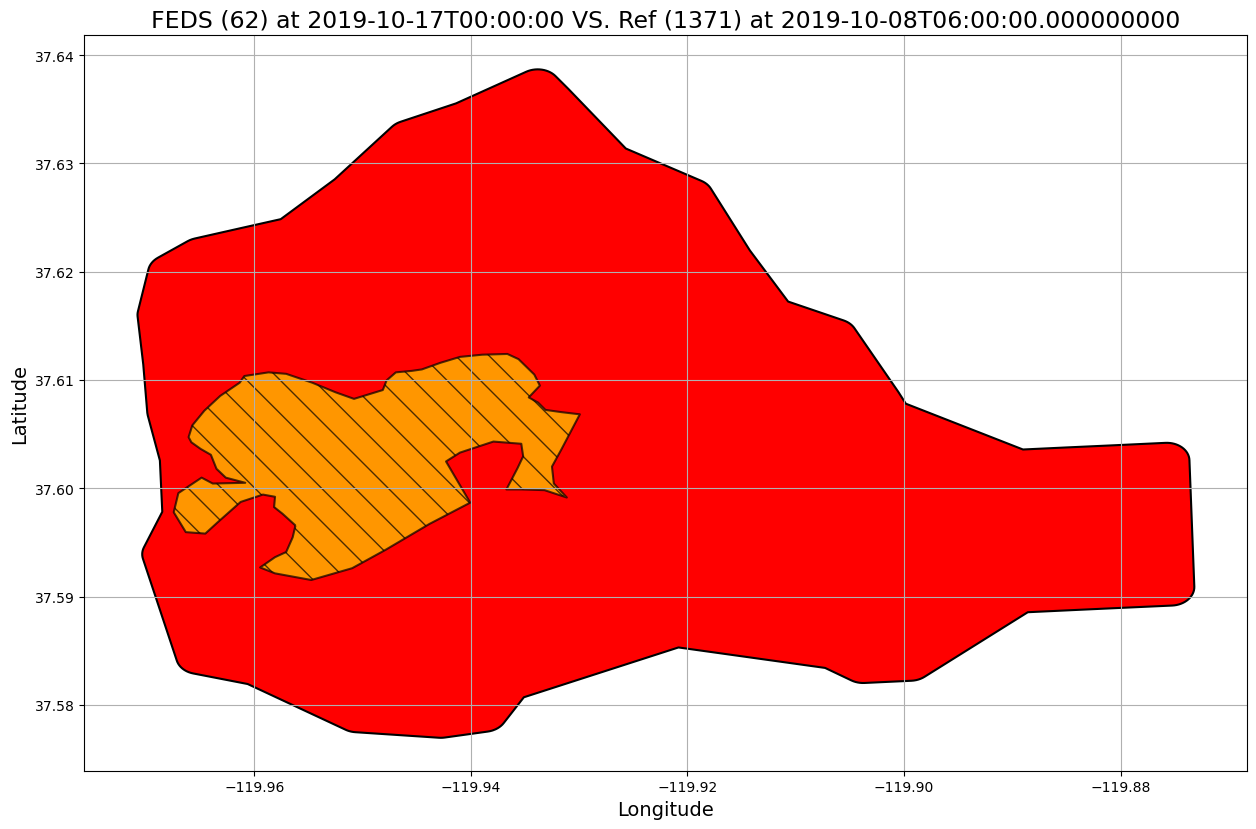

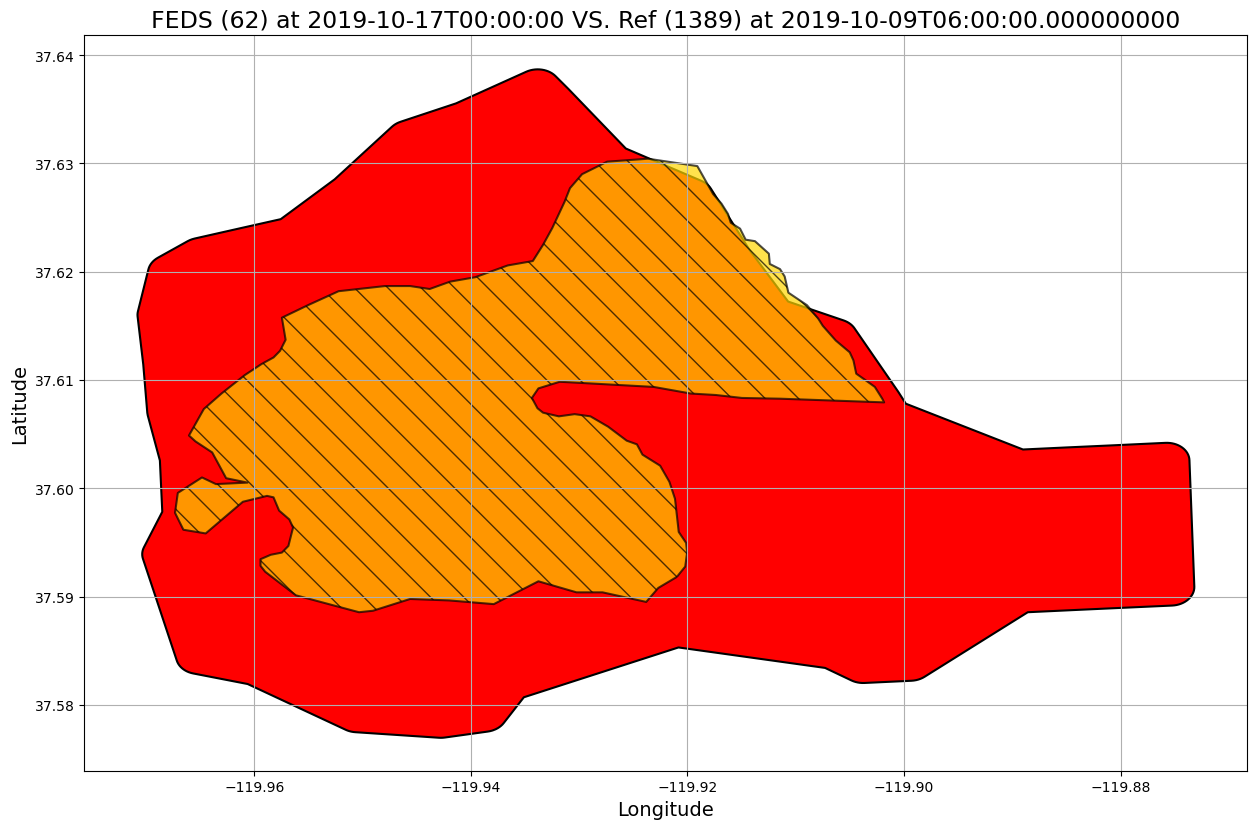

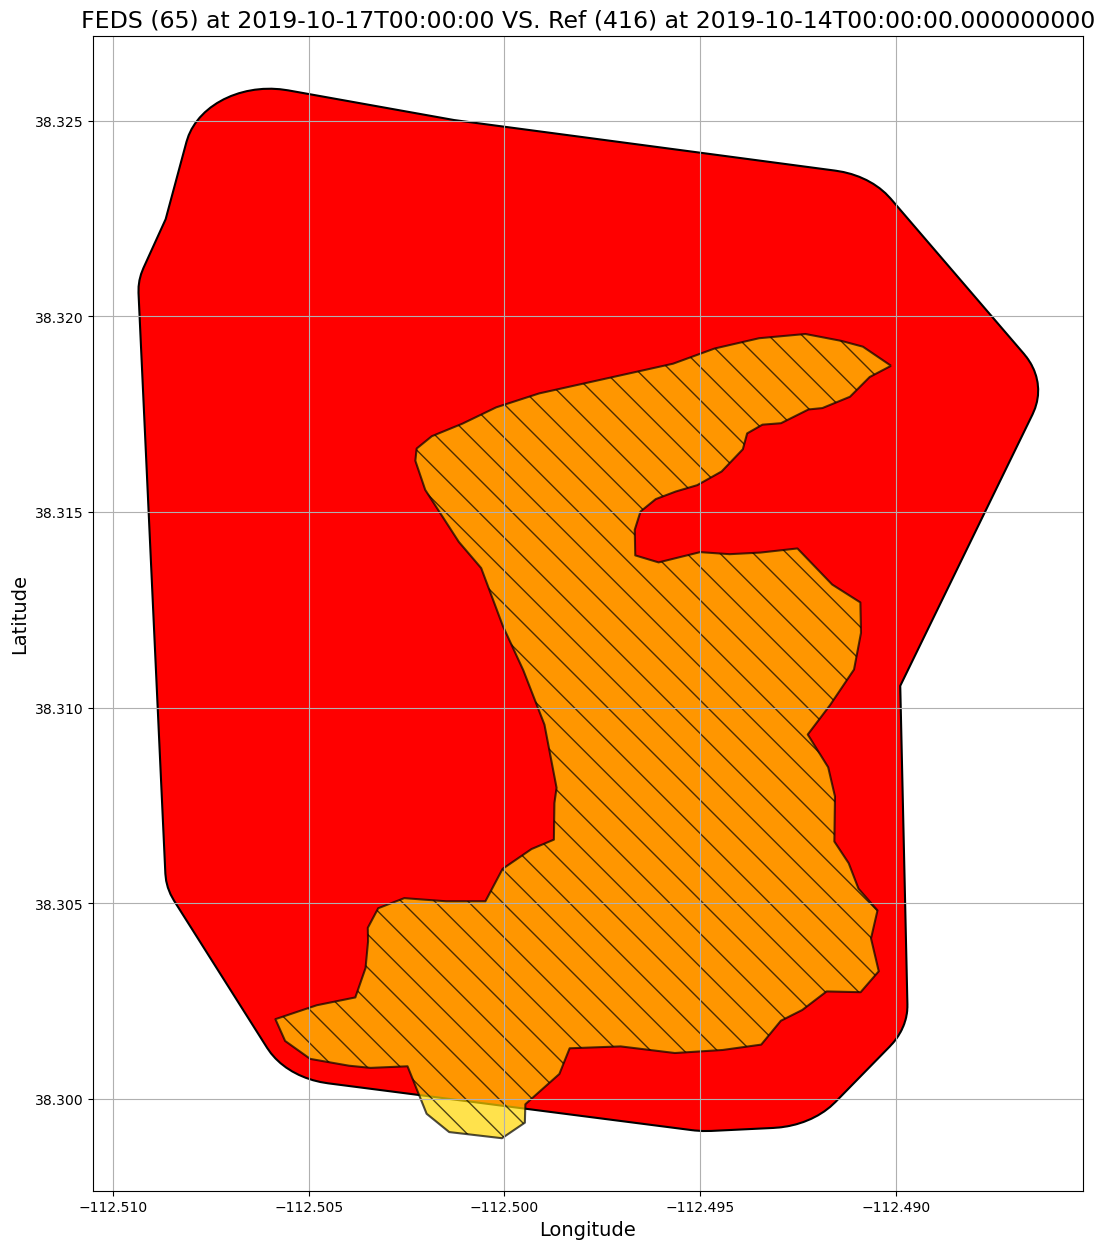

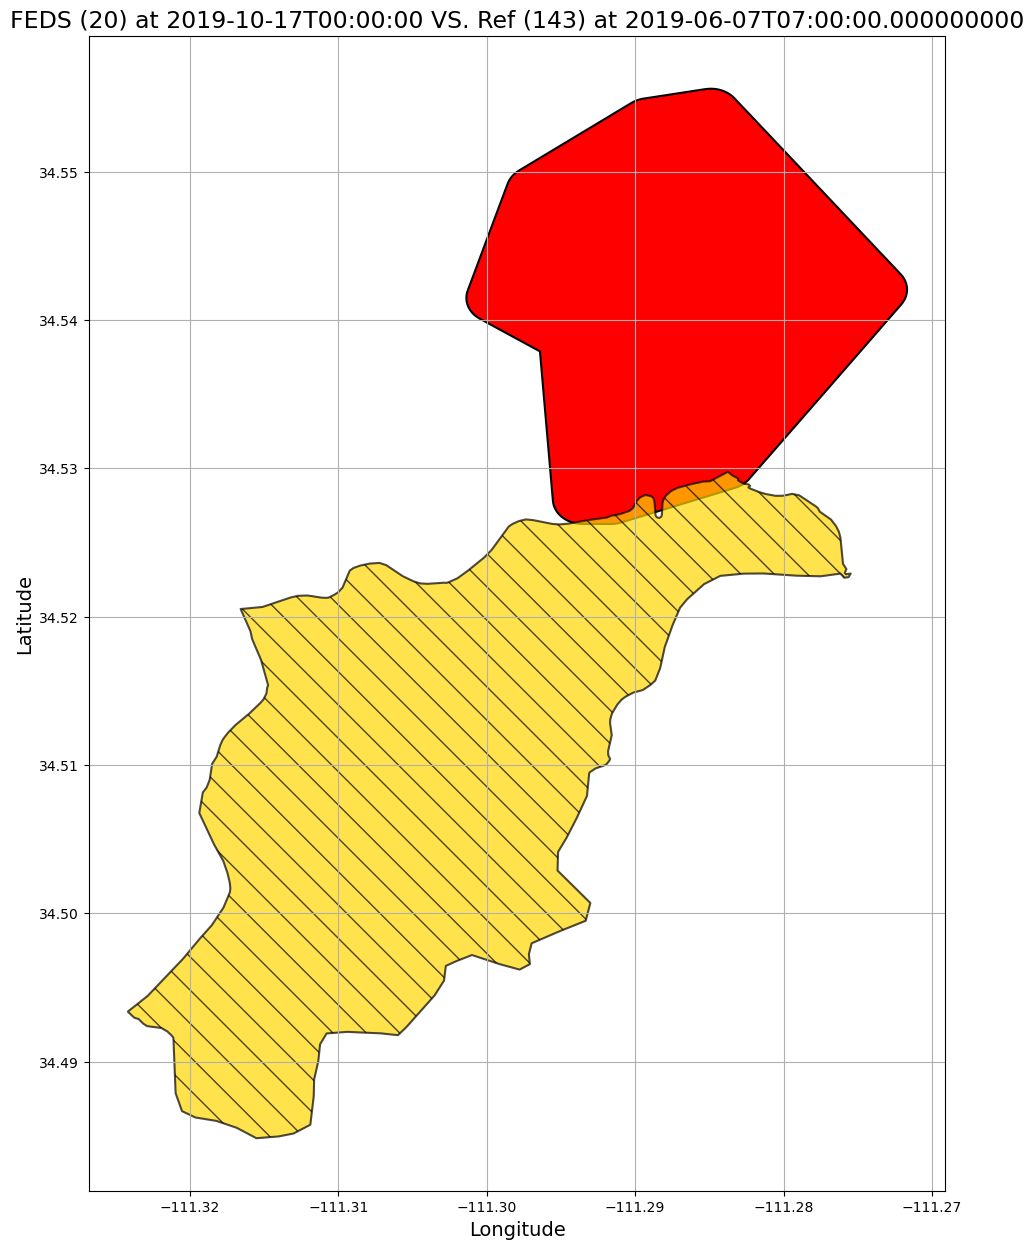

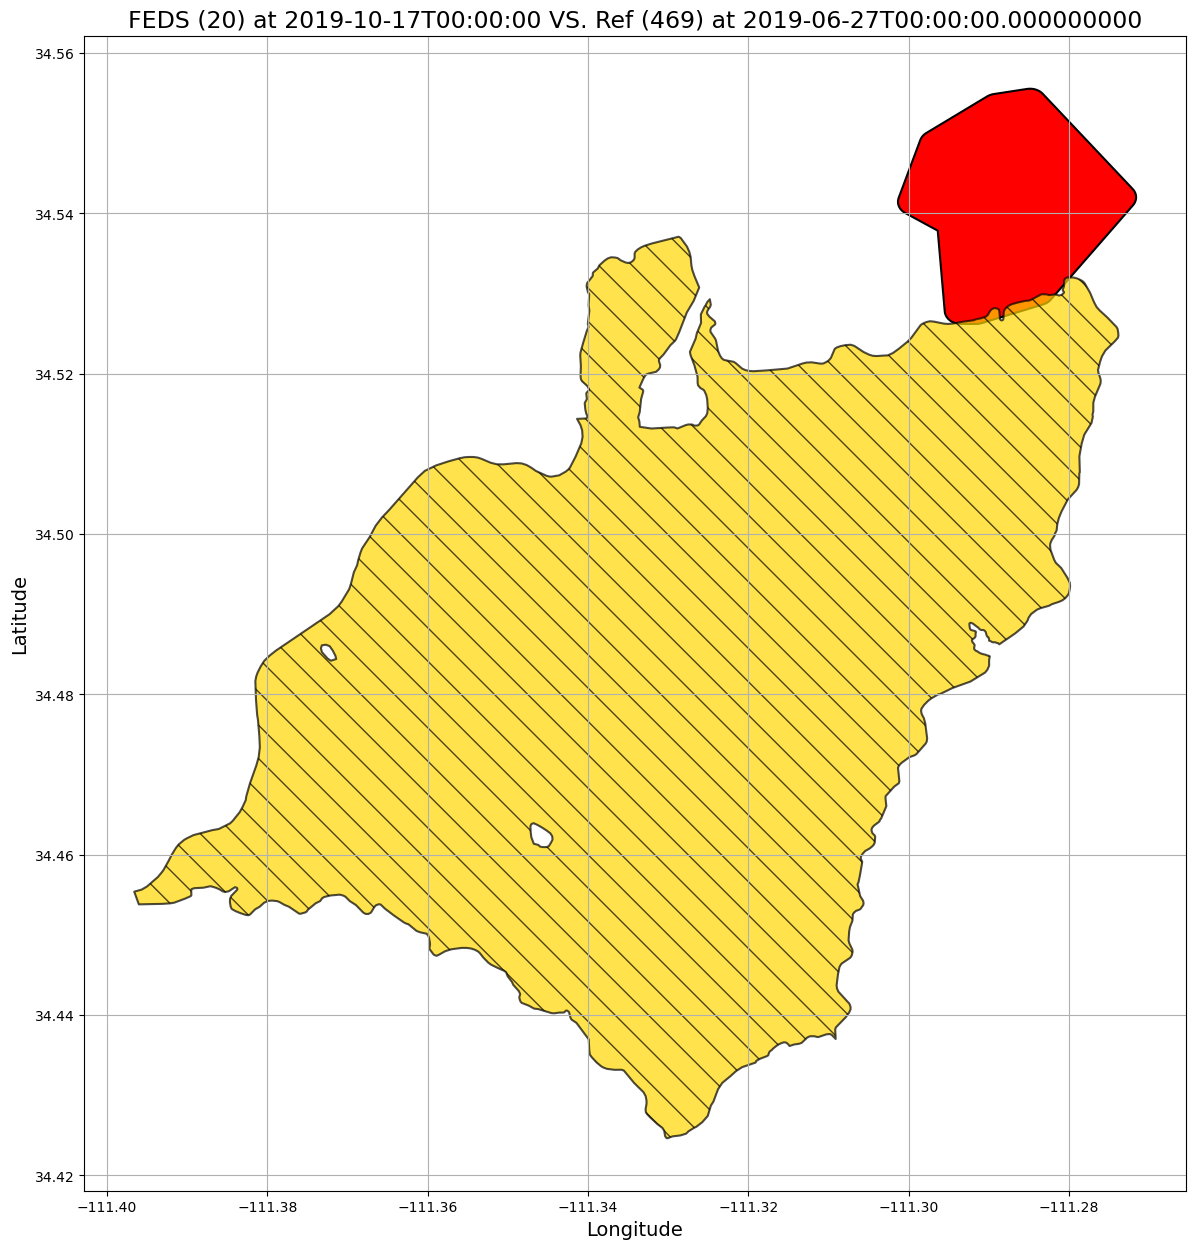

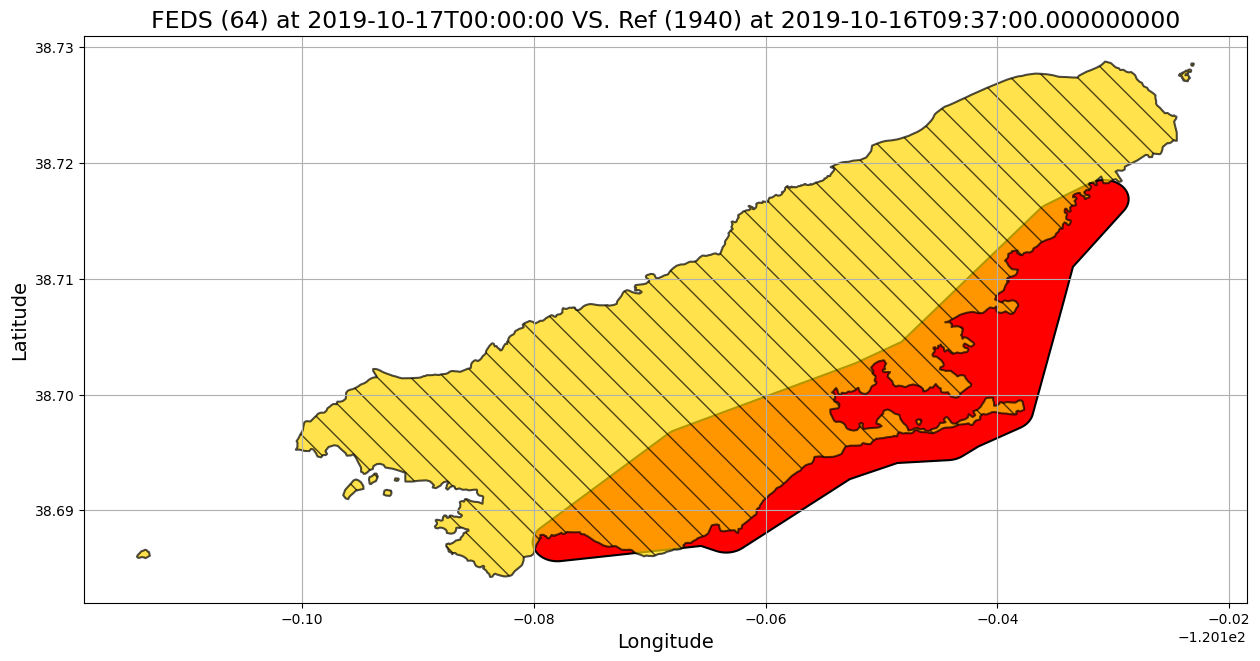

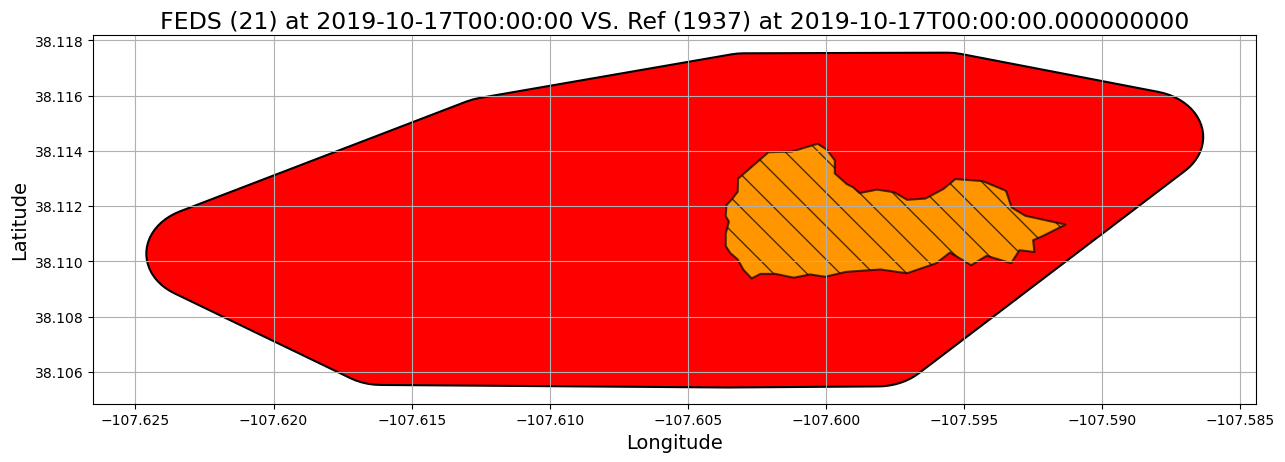

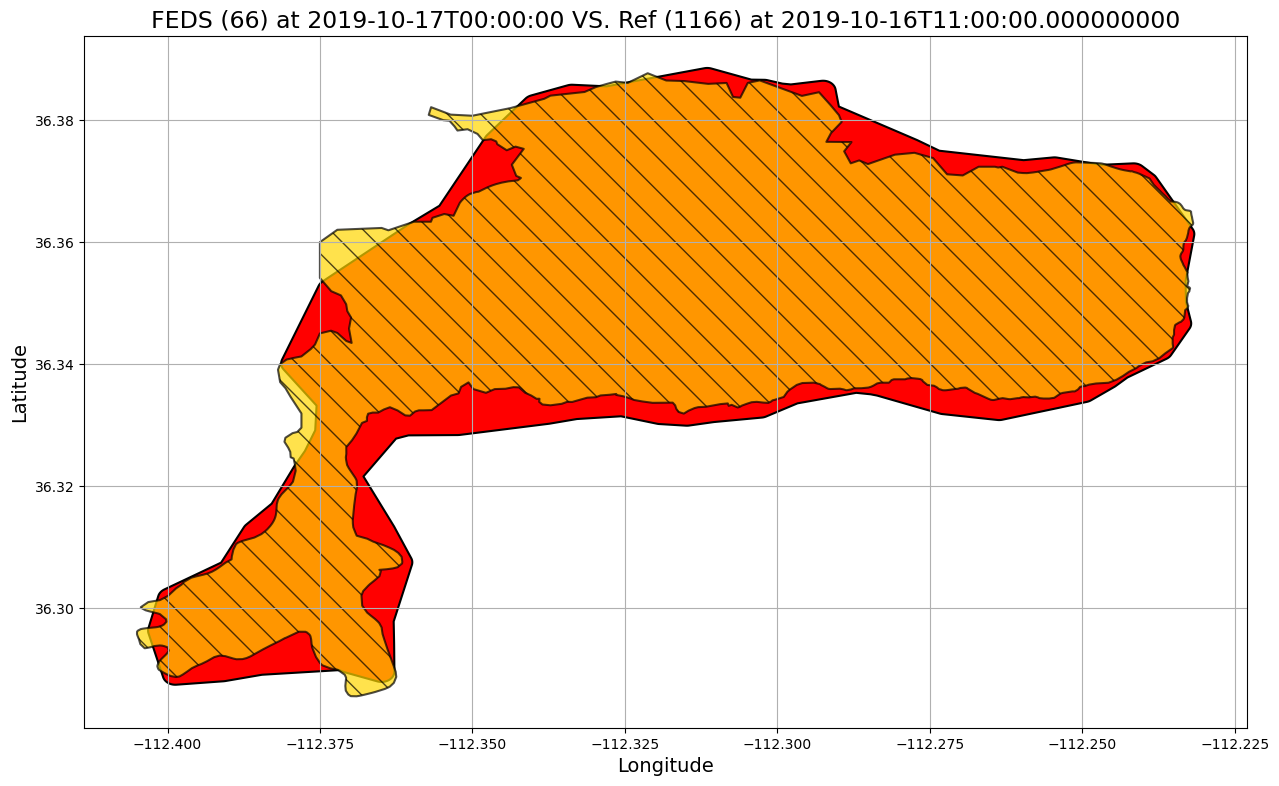

PLOTTING COMPLETE
VERBOSE: OPEN RASTER
VERBOSE: RASTER CRS
VERBOSE: PROJECT DIFF_AREA
VERBOSE: OLD CRS: epsg:3857


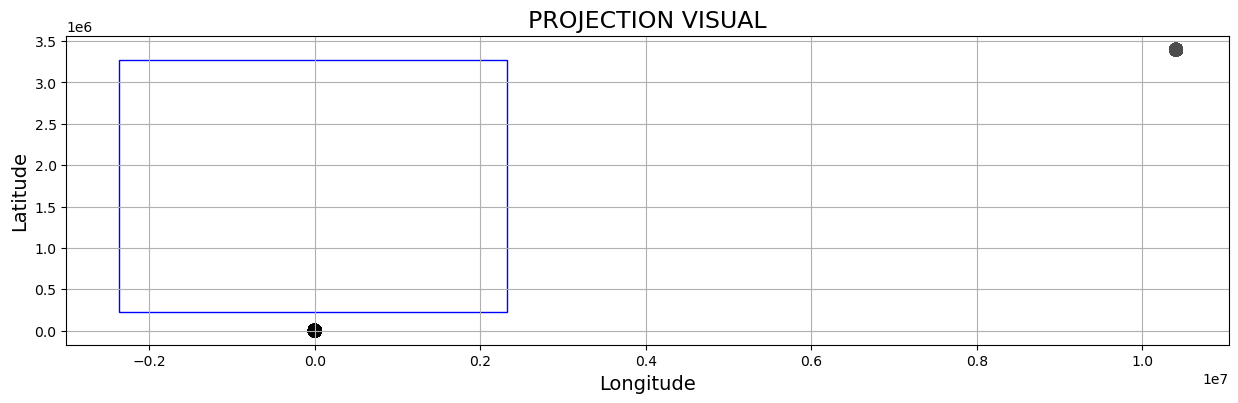

VERBOSE: NEW CRS: PROJCS["NAD_1983_Contiguous_USA_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]
VERBOSE: TIF CRS: EPSG:5070
VERBOSE: MASK TIF
VERBOSE: GEOM BOUNDS
10406912.355703652 3395123.5339027112 10406912.455038328 3395123.6440425813
VERBOSE: TIF BOUNDS
(-2362395.0, 221265.0, 2327655.0, 3267405.0)
VERBOSE: CALCULATION EXTRACTION
VERBOSE: PROJECT DIFF_AREA
VERBOSE: OLD CRS: epsg:3857


/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


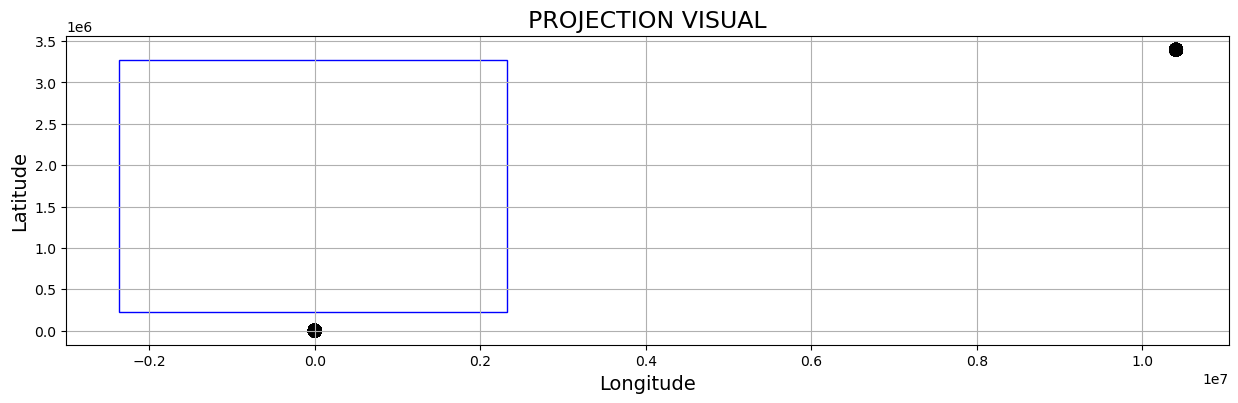

VERBOSE: NEW CRS: PROJCS["NAD_1983_Contiguous_USA_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]
VERBOSE: TIF CRS: EPSG:5070
VERBOSE: MASK TIF
VERBOSE: GEOM BOUNDS
10406923.960957253 3395139.3183222376 10406924.053612547 3395139.4311055294
VERBOSE: TIF BOUNDS
(-2362395.0, 221265.0, 2327655.0, 3267405.0)
VERBOSE: CALCULATION EXTRACTION
VERBOSE: PROJECT DIFF_AREA
VERBOSE: OLD CRS: epsg:3857


/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


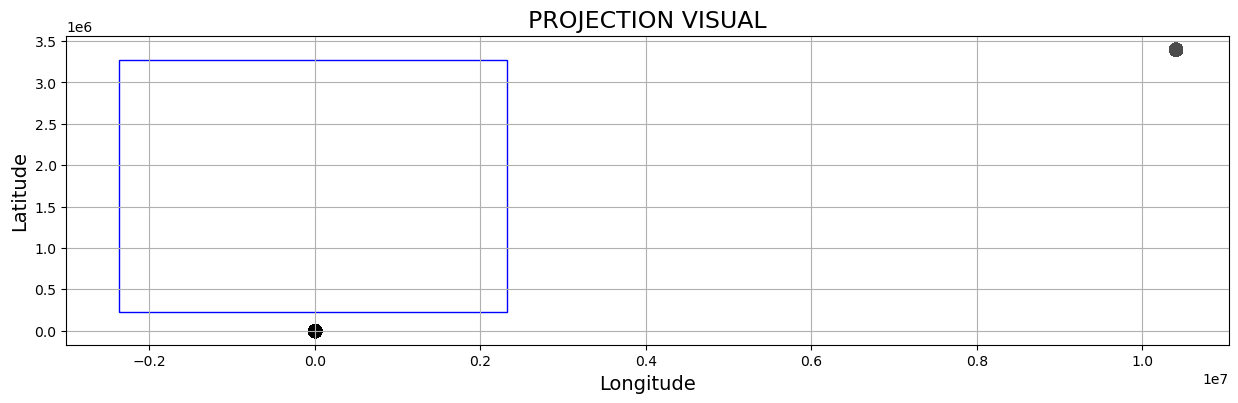

VERBOSE: NEW CRS: PROJCS["NAD_1983_Contiguous_USA_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]
VERBOSE: TIF CRS: EPSG:5070
VERBOSE: MASK TIF
VERBOSE: GEOM BOUNDS
10406923.960957253 3395139.3183222376 10406924.053612547 3395139.425712175
VERBOSE: TIF BOUNDS
(-2362395.0, 221265.0, 2327655.0, 3267405.0)
VERBOSE: CALCULATION EXTRACTION
VERBOSE: PROJECT DIFF_AREA
VERBOSE: OLD CRS: epsg:3857


/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


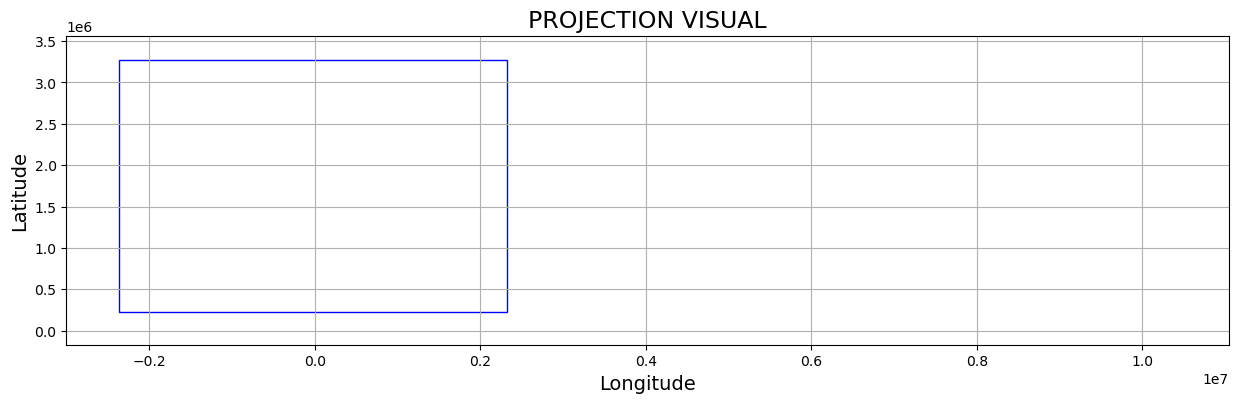

VERBOSE: NEW CRS: PROJCS["NAD_1983_Contiguous_USA_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]
VERBOSE: TIF CRS: EPSG:5070
VERBOSE: MASK TIF
VERBOSE: GEOM BOUNDS
10406922.204435691 3395138.015015452 10406922.237318393 3395138.0672748527
VERBOSE: TIF BOUNDS
(-2362395.0, 221265.0, 2327655.0, 3267405.0)
VERBOSE: CALCULATION EXTRACTION
VERBOSE: PROJECT DIFF_AREA
VERBOSE: OLD CRS: epsg:3857


/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


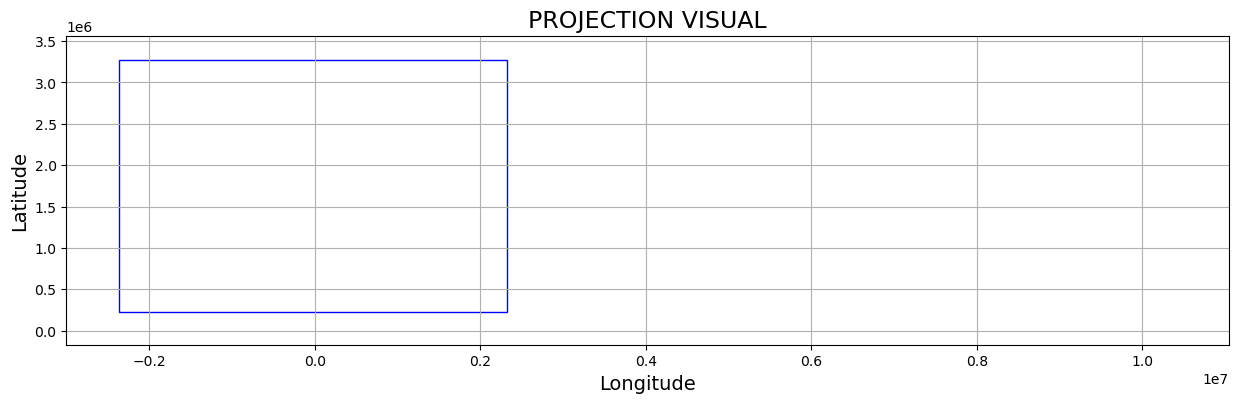

VERBOSE: NEW CRS: PROJCS["NAD_1983_Contiguous_USA_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]
VERBOSE: TIF CRS: EPSG:5070
VERBOSE: MASK TIF
VERBOSE: GEOM BOUNDS
10406915.970254324 3395125.2404629565 10406916.051921269 3395125.341006578
VERBOSE: TIF BOUNDS
(-2362395.0, 221265.0, 2327655.0, 3267405.0)
VERBOSE: CALCULATION EXTRACTION
VERBOSE: PROJECT DIFF_AREA
VERBOSE: OLD CRS: epsg:3857


/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


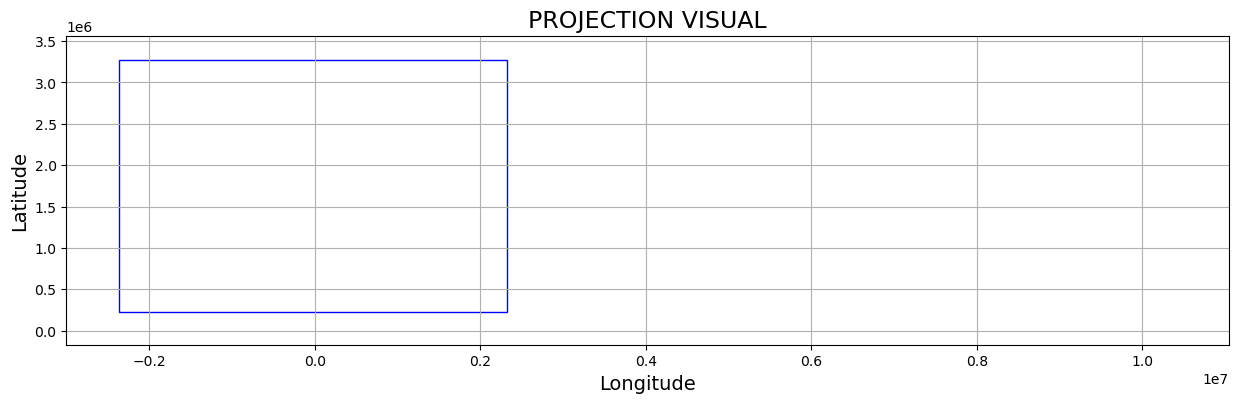

VERBOSE: NEW CRS: PROJCS["NAD_1983_Contiguous_USA_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]
VERBOSE: TIF CRS: EPSG:5070
VERBOSE: MASK TIF
VERBOSE: GEOM BOUNDS
10406915.970254324 3395125.2404629565 10406916.051921269 3395125.341006578
VERBOSE: TIF BOUNDS
(-2362395.0, 221265.0, 2327655.0, 3267405.0)
VERBOSE: CALCULATION EXTRACTION
VERBOSE: PROJECT DIFF_AREA
VERBOSE: OLD CRS: epsg:3857


/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


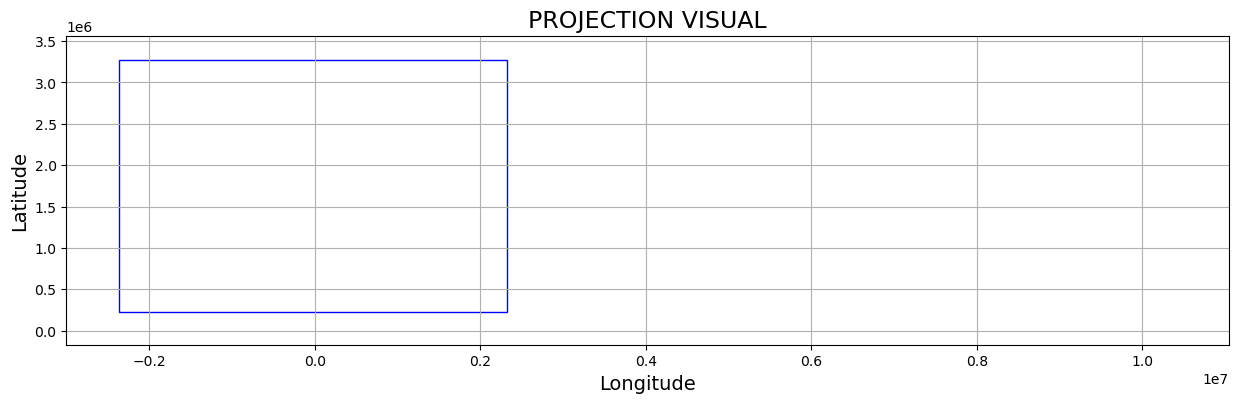

VERBOSE: NEW CRS: PROJCS["NAD_1983_Contiguous_USA_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]
VERBOSE: TIF CRS: EPSG:5070
VERBOSE: MASK TIF
VERBOSE: GEOM BOUNDS
10406920.068724763 3395132.905676717 10406920.097001143 3395132.933476282
VERBOSE: TIF BOUNDS
(-2362395.0, 221265.0, 2327655.0, 3267405.0)
VERBOSE: CALCULATION EXTRACTION
VERBOSE: PROJECT DIFF_AREA
VERBOSE: OLD CRS: epsg:3857


/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


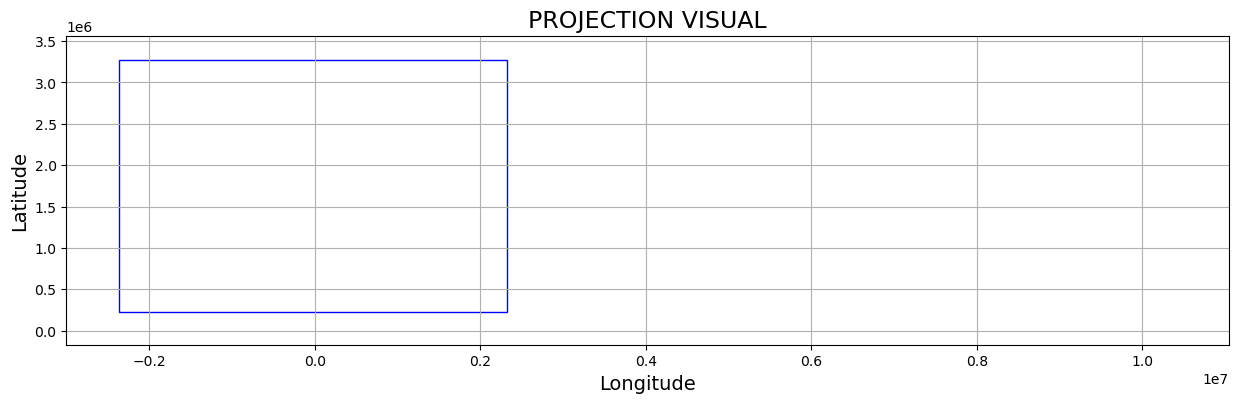

VERBOSE: NEW CRS: PROJCS["NAD_1983_Contiguous_USA_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]
VERBOSE: TIF CRS: EPSG:5070
VERBOSE: MASK TIF
VERBOSE: GEOM BOUNDS
10406923.550040554 3395132.337461253 10406923.589513848 3395132.411385609
VERBOSE: TIF BOUNDS
(-2362395.0, 221265.0, 2327655.0, 3267405.0)
VERBOSE: CALCULATION EXTRACTION
VERBOSE: PROJECT DIFF_AREA
VERBOSE: OLD CRS: epsg:3857


/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


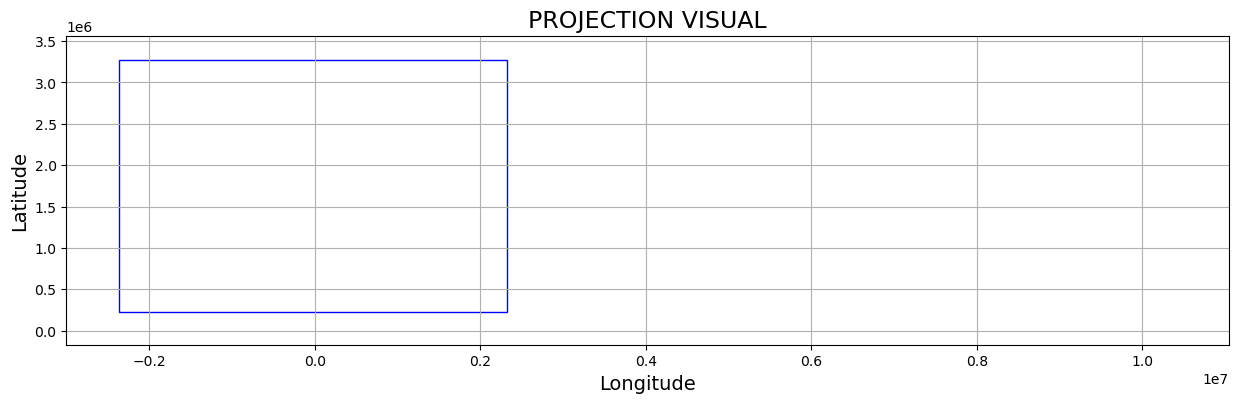

VERBOSE: NEW CRS: PROJCS["NAD_1983_Contiguous_USA_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]
VERBOSE: TIF CRS: EPSG:5070
VERBOSE: MASK TIF
VERBOSE: GEOM BOUNDS
10406923.536887273 3395132.248800941 10406923.625012916 3395132.411385609
VERBOSE: TIF BOUNDS
(-2362395.0, 221265.0, 2327655.0, 3267405.0)
VERBOSE: CALCULATION EXTRACTION
VERBOSE: PROJECT DIFF_AREA
VERBOSE: OLD CRS: epsg:3857


/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


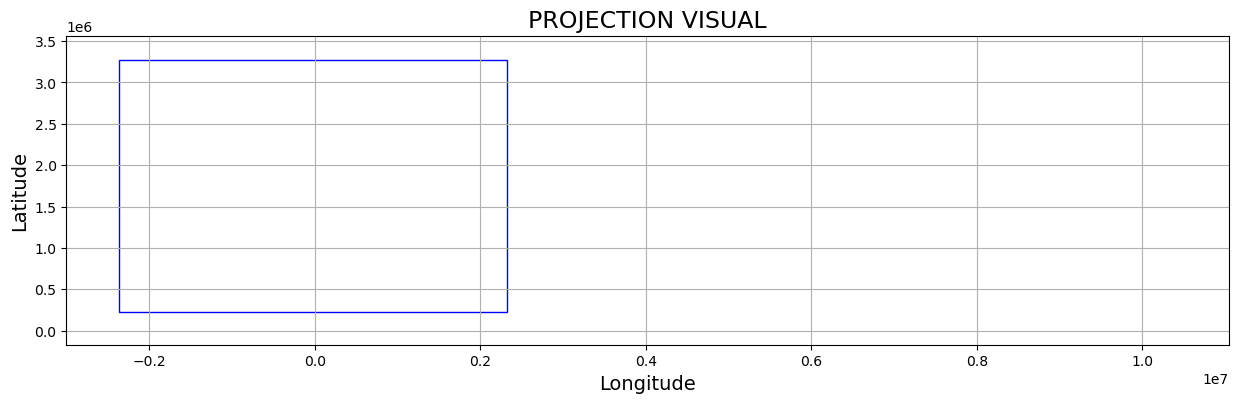

VERBOSE: NEW CRS: PROJCS["NAD_1983_Contiguous_USA_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]
VERBOSE: TIF CRS: EPSG:5070
VERBOSE: MASK TIF
VERBOSE: GEOM BOUNDS
10406915.047598604 3395125.4984847154 10406915.086750556 3395125.6075348295
VERBOSE: TIF BOUNDS
(-2362395.0, 221265.0, 2327655.0, 3267405.0)
VERBOSE: CALCULATION EXTRACTION
VERBOSE: PROJECT DIFF_AREA
VERBOSE: OLD CRS: epsg:3857


/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


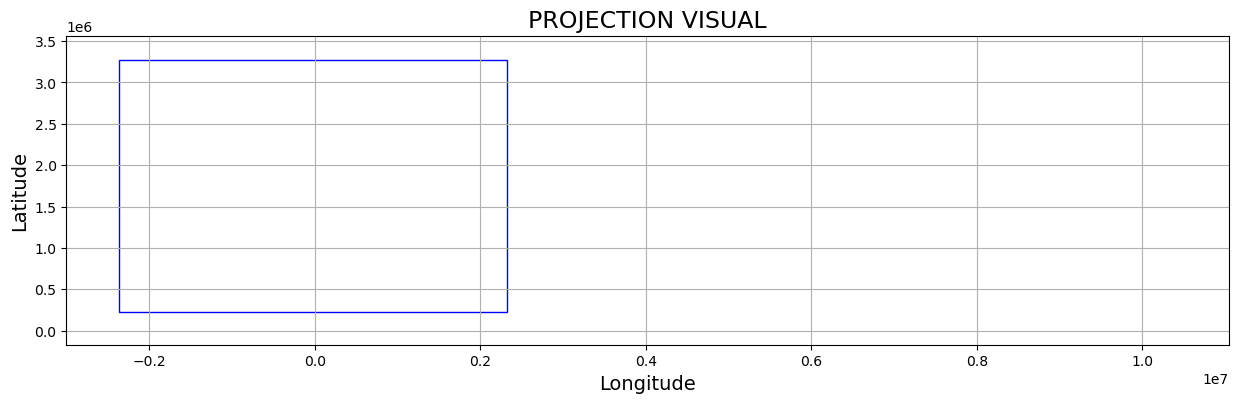

VERBOSE: NEW CRS: PROJCS["NAD_1983_Contiguous_USA_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]
VERBOSE: TIF CRS: EPSG:5070
VERBOSE: MASK TIF
VERBOSE: GEOM BOUNDS
10406923.239760006 3395137.621348989 10406923.261295428 3395137.6611798955
VERBOSE: TIF BOUNDS
(-2362395.0, 221265.0, 2327655.0, 3267405.0)
VERBOSE: CALCULATION EXTRACTION
VERBOSE: PROJECT DIFF_AREA
VERBOSE: OLD CRS: epsg:3857


/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


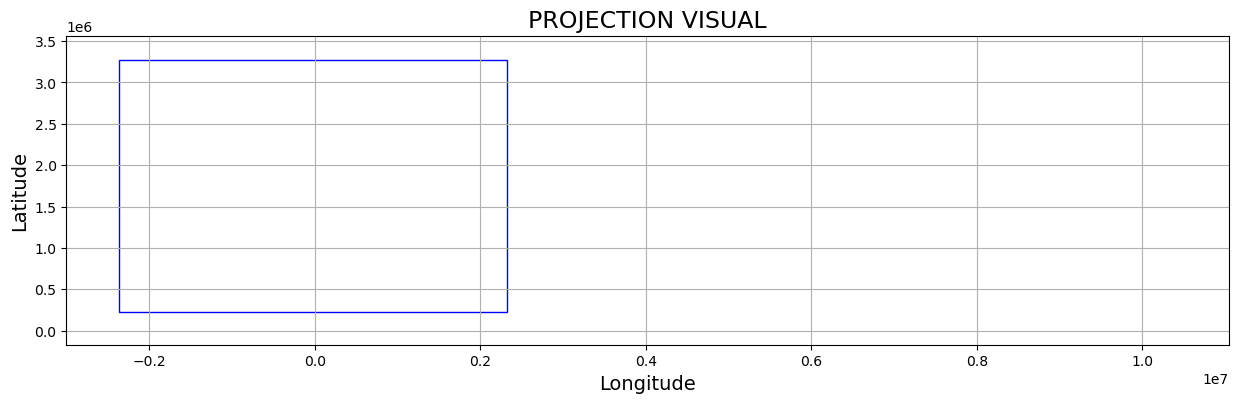

VERBOSE: NEW CRS: PROJCS["NAD_1983_Contiguous_USA_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]
VERBOSE: TIF CRS: EPSG:5070
VERBOSE: MASK TIF
VERBOSE: GEOM BOUNDS
10406921.569176279 3395132.093584159 10406921.67350621 3395132.2953450596
VERBOSE: TIF BOUNDS
(-2362395.0, 221265.0, 2327655.0, 3267405.0)
VERBOSE: CALCULATION EXTRACTION


CSV output complete! Check file /projects/my-public-bucket/VEDA-PEC/results/compare_interagen

/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/env-feds-new-new/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
# create instances to track properties
print('You may see an ERROR 1 occur; ignore this unless block throws actual exception...')

feds_firenrt = InputFEDS(
                 feds_title, 
                 feds_collection, 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 feds_access_type,
                 feds_limit,
                 feds_filter,
                 feds_apply_finalfire
                )

nifc_search = InputReference( 
                 search_start,
                 search_stop,
                 search_bbox,
                 crs,
                 ref_title,
                 ref_control_type,
                 ref_custom_url,
                 ref_custom_read_type,
                 ref_filter,
                )

my_output = OutputCalculation(
                feds_firenrt,
                nifc_search,
                output_format, 
                output_maap_url,
                day_search_range,
                print_on,
                plot_on
                )

### Tif Analysis on Symmetric Difference Matches (Exceeding Areas of FEDS over Reference)

This function built into the Output Class demonstrates research application uses of FEDS-PEC

Given the output matches, give a tif path, calculations of interest, and optional time (in days) limit. This will return associated TIF values for the symmetric difference of FEDS over the reference (FEDS - reference)

In [ ]:
# tif_path - replace with your own path
tif_path = "/projects/shared-buckets/gsfc_landslides/LANDFIRE/LF2022_FBFM40_220_CONUS/Tif/LC22_F40_220.tif" # "/projects/CONUS-Down/LF2020_SlpD_220_CONUS/Tif/LC20_SlpD_220.tif"
# array of values returned as get_res
get_res = my_output.tif_analysis(tif_path, "MEDIAN", 2)

### Export Polygons

Provide a path along with polygons, and then call on the `export_polygons` method for your OutputCalculation object

In [ ]:
# name your file
shp_file_name = "feds_used"
# resuses the same dir as the csv export 
output_shp_path = f"{user_path}/{shp_file_name}.shp"

my_output.export_polygons(feds_firenrt.polygons, output_shp_path)